In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy
import pathlib


In [4]:
path_results =  pathlib.Path('./outputs')
if not(path_results.exists()):
    path_results.mkdir()
path_output = path_results
# path_output = path_results / pathlib.Path('nlm')
# if not(path_output.exists()):
#     path_output.mkdir()

In [5]:
FONT_SIZE = 30

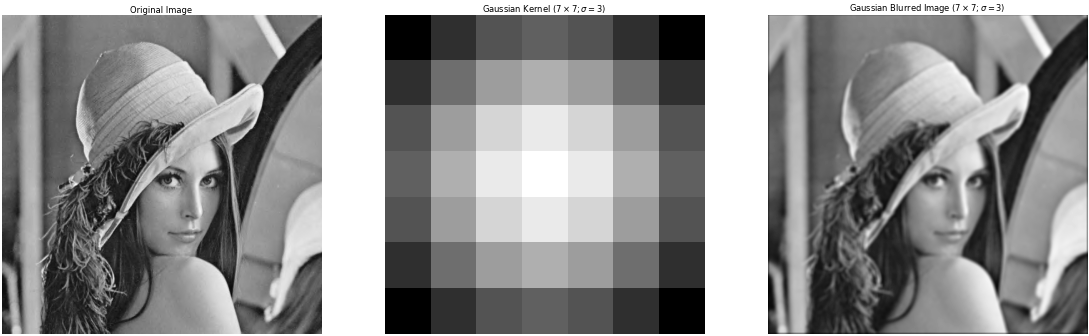

In [6]:

import matplotlib.pyplot
import scipy.signal

import lasp.io
import lasp.filters


img = lasp.io.read(pathlib.Path('lena.tif'))
# img = lasp.io.read(pathlib.Path('phantom.npy'))
h = lasp.filters.gaussian_filter(size=7, sigma=3)
img_blurred = numpy.array(scipy.signal.convolve2d(img, h, mode='same'))

lasp.io.save(img, path_output / 'img.png')
lasp.io.save(h, path_output / 'h.png')
lasp.io.save(img_blurred, path_output / 'img_blurred.png')


figure = matplotlib.pyplot.figure(figsize=(70, 70), dpi=20)

_ = matplotlib.pyplot.subplot(1, 3, 1)
_ = matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.title(
    label = 'Original Image', 
    fontsize = FONT_SIZE
)
_ = matplotlib.pyplot.imshow(img, cmap='gray')

_ = matplotlib.pyplot.subplot(1, 3, 2)
_ = matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.title(
    label = 'Gaussian Kernel ($7 \\times 7; \sigma = 3$)', 
    fontsize = FONT_SIZE
)
_ = matplotlib.pyplot.imshow(h, cmap='gray')

_ = matplotlib.pyplot.subplot(1, 3, 3)
_ = matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.title(
    label = 'Gaussian Blurred Image ($7 \\times 7; \sigma = 3$)', 
    fontsize = FONT_SIZE
)
_ = matplotlib.pyplot.imshow(img_blurred, cmap='gray')


In [7]:
# Convert in double
img = img.astype(numpy.double)
h = h.astype(numpy.double)
img_blurred = img_blurred.astype(numpy.double)

In [8]:
import lasp.utils

def fourier_diagonalization(kernel: numpy.ndarray, shape_out: numpy.ndarray) -> numpy.ndarray:
    nb_rows, nb_cols = kernel.shape
    kernel_padded = numpy.zeros(shape_out)
    kernel_padded[:nb_rows, :nb_cols] = numpy.copy(kernel)
    # print(kernel_padded)
    center = numpy.round(numpy.array(kernel.shape)/2).astype(int) 
    # print(center)
    circshifted = lasp.utils.circshift(kernel_padded, 1-center)
    # print(circshifted)
    return numpy.fft.fft2(circshifted)

def normalize(img: numpy.ndarray) -> numpy.ndarray:
    i_min = numpy.min(img)
    i_max = numpy.max(img)
    normalized = (img - i_min) / (i_max - i_min)
    return normalized


# def denormalize(img: numpy.ndarray, i_min: int, i_max: int) -> numpy.ndarray:
#     denormalized = (i_max - i_min) * img + i_min
#     return denormalized

In [28]:
import PIL.Image
import lasp.thresholding
import lasp.differential

def split_bregman(
    g: numpy.ndarray,
    h: numpy.ndarray,
    lamda: float,
    mu: float,
    sigma: float,
    nb_iterations: int
) -> numpy.ndarray:


    # Discrete derivation matrix
    ## Creation
    ## REVERSE SHAPE IF g ISNT SQUARRED
    DX = lasp.differential.differential_matrix(
        derivate = lasp.differential.dx,
        shape_out = g.shape
    )
    DY = lasp.differential.differential_matrix(
        derivate = lasp.differential.dy,
        shape_out = g.shape
    )
    DXT = lasp.differential.differential_matrix(
        derivate = lasp.differential.dxT,
        shape_out = g.shape
    )
    DYT = lasp.differential.differential_matrix(
        derivate = lasp.differential.dyT,
        shape_out = g.shape
    )
    ## Fourrier diagonalization
    DX_diag = fourier_diagonalization(DX, numpy.array(g.shape))
    DY_diag = fourier_diagonalization(DY, numpy.array(g.shape))
    DXT_diag = fourier_diagonalization(DXT, numpy.array(g.shape))
    DYT_diag = fourier_diagonalization(DYT, numpy.array(g.shape))


    # Create laplacian approximation Delta
    laplacian = numpy.array(
        [
            [0, -1, 0], 
            [-1, 4, -1], 
            [0, -1, 0]
        ],
        dtype=numpy.double
    )
    laplacian_diag = fourier_diagonalization(laplacian, numpy.array(g.shape))
    # # laplacian_diag = DXT_diag*DX_diag + DYT_diag*DY_diag
    # laplacian_diag = numpy.conj(DX_diag)*DX_diag + numpy.conj(DY_diag)*DY_diag
    
    
    # Compute eigens values of H_{BCCB}
    ## H_{BCCB} = F^{T} h_bccb_diag F
    h_bccb_diag = fourier_diagonalization(h, numpy.array(g.shape))
    # h2_bccb_diag = h_bccb_diag*numpy.conj(h_bccb_diag)
    h2_bccb_diag = numpy.abs(h_bccb_diag)**2


    f = numpy.copy(g)
    d_x = numpy.zeros_like(g)
    d_y = numpy.zeros_like(g)
    b_x = numpy.zeros_like(g)
    b_y = numpy.zeros_like(g)

    
    # Compute constant terms
    cst1 = lamda*h2_bccb_diag + (mu+sigma) * laplacian_diag
    print((cst1 != 0).all())
    # print('cst1_min: {} \t cst1_max: {}'.format(numpy.min(cst1), numpy.max(cst1)))

    ## H^T S^{T} y
    # cst2 = numpy.fft.ifft2(h_bccb_diag * numpy.fft.fft2(ST(g)))
    cst2 = lamda * numpy.conj(h_bccb_diag) * numpy.fft.fft2(g)
    # print('cst2_min: {} \t cst2_max: {}'.format(numpy.min(cst2), numpy.max(cst2)))


    for no_iter in range(0, nb_iterations):

        # print(numpy.min(f), numpy.max(f))
        # print('\nIter {}'.format(no_iter))

        # Compute f^{k+1}
        a = cst1
        # b = numpy.fft.fft2(sigma*(Dxt(d_x-b_x)+Dyt(d_y-b_y))) + cst2
        b = numpy.fft.fft2(sigma*(lasp.differential.dxT(d_x-b_x) + lasp.differential.dyT(d_y-b_y))) + cst2
        # print('b_min: {} \t b_max: {}'.format(numpy.min(b), numpy.max(b)))
        
        f = numpy.real(numpy.fft.ifft2(b / a))
        if (no_iter%20) == 0:
            print('f_min: {} \t f_max: {}'.format(numpy.min(f), numpy.max(f))) 
        # print(f)

        
        # grad_f = numpy.array([ Dx(f), Dy(f) ])
        grad_f = numpy.array([ lasp.differential.dx(f), lasp.differential.dy(f) ])
        
        # print('grad_x_min: {} \t grad_x_max: {}'.format(
        #         numpy.min(grad_f[0]), 
        #         numpy.max(grad_f[0])
        #     )
        # )

        # print('grad_y_min: {} \t grad_y_max: {}'.format(
        #         numpy.min(grad_f[1]), 
        #         numpy.max(grad_f[1])
        #     )
        # )

        # Compute d_{x}^{k+1} and d_{y}^{k+1}
        s_x = grad_f[0] + b_x
        s_y = grad_f[1] + b_y
        s = s_x + s_y * 1j
        ss = lasp.thresholding.soft(s, 1 / sigma)
        d_x = numpy.real(ss)
        d_y = numpy.imag(ss)

        # s = numpy.sqrt(s_x**2 + s_y**2)
        # coef = numpy.max(s - (beta1 / sigma), 0)
        # d_x = numpy.where(s > 0, coef * (s_x / s), d_x)
        # d_y = numpy.where(s > 0, coef * (s_y / s), d_y)

        # print('dx_min: {} \t dx_max: {}'.format(numpy.min(d_x), numpy.max(d_x)))
        # print('dy_min: {} \t dy_max: {}'.format(numpy.min(d_y), numpy.max(d_y)))


        # Compute b_{x}^{k+1} and b_{y}^{k+1}
        b_x = b_x + (grad_f[0] - d_x)
        b_y = b_y + (grad_f[1] - d_y)

        # print('bx_min: {} \t bx_max: {}'.format(numpy.min(b_x), numpy.max(b_x)))
        # print('by_min: {} \t by_max: {}'.format(numpy.min(b_y), numpy.max(b_y)))

    # print(g.shape, f.shape)


    return f

In [29]:
# f = split_bregman(img_blurred, h, lamda=1, mu=1/100, sigma=2/100, nb_iterations=300)

# normalized = normalize(f)
# figure = matplotlib.pyplot.figure(figsize=(30, 30), dpi=20)
# matplotlib.pyplot.axis('off')
# _ = matplotlib.pyplot.imshow(normalized, cmap='gray')

In [30]:
# f = split_bregman(img_blurred, h, lamda=100, mu=1, sigma=2, nb_iterations=40)
# normalized = normalize(f)
# grey_level = numpy.round(normalized*255).astype(numpy.uint8)
# figure = matplotlib.pyplot.figure(figsize=(5, 5))
# matplotlib.pyplot.axis('off')
# _ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
# lasp.io.save(grey_level, path_output / 'res_lambda=100_mu=1_sigma=2_iter=300.png')

True
f_min: -0.23430244177168702 	 f_max: 1.9317802656923133
f_min: -3.158178673842192 	 f_max: 4.656427676019275
f_min: -5.108397699385493 	 f_max: 7.726786791367099
f_min: -6.006367626604447 	 f_max: 7.854226485604647
f_min: -6.709861702858028 	 f_max: 9.767014235428032
f_min: -9.35100254345625 	 f_max: 8.641933322255875
f_min: -10.46633115937843 	 f_max: 11.703290597828525
f_min: -10.110389049777378 	 f_max: 11.66205859934995
f_min: -11.403128430503003 	 f_max: 12.286377542956043
f_min: -12.648030335139735 	 f_max: 15.253200778667217
f_min: -18.7227665003218 	 f_max: 26.153289972099333
f_min: -17.42373124425741 	 f_max: 17.237579043615114
f_min: -19.99862326368766 	 f_max: 22.25809310084604
f_min: -17.65386851920119 	 f_max: 27.36105116345021
f_min: -23.680520689769523 	 f_max: 25.922966268593402


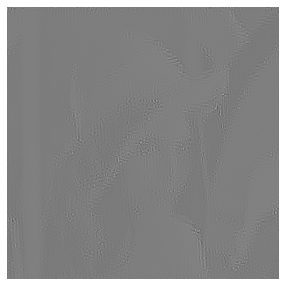

In [37]:
f = split_bregman(normalize(img_blurred), h, lamda=100, mu=1, sigma=2, nb_iterations=300)
normalized = normalize(f)
grey_level = numpy.round(normalized*255).astype(numpy.uint8)
figure = matplotlib.pyplot.figure(figsize=(5, 5))
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
lasp.io.save(grey_level, path_output / 'res_lambda=100_mu=1_sigma=2_iter=300.png')

In [34]:
# f = split_bregman(normalize(img_blurred), h, lamda=1, mu=0.1, sigma=0.2, nb_iterations=300)
# normalized = normalize(f)
# grey_level = numpy.round(normalized*255).astype(numpy.uint8)
# figure = matplotlib.pyplot.figure(figsize=(5, 5))
# matplotlib.pyplot.axis('off')
# _ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
# lasp.io.save(grey_level, path_output / 'res_lambda=100_mu=1_sigma=2_iter=300.png')

In [35]:
# f = split_bregman(img_blurred, h, lamda=100, mu=1*2, sigma=2, nb_iterations=300)
# normalized = normalize(f)
# grey_level = numpy.round(normalized*255).astype(numpy.uint8)
# figure = matplotlib.pyplot.figure(figsize=(5, 5))
# matplotlib.pyplot.axis('off')
# _ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
# lasp.io.save(grey_level, path_output / 'res_lambda=100_mu=2_sigma=2_iter=300.png')

In [36]:
# f = split_bregman(img_blurred, h, lamda=100, mu=1, sigma=2, nb_iterations=300)
# f = split_bregman(img_blurred, h, lamda=200, mu=1, sigma=2, nb_iterations=300)
# normalized = normalize(f)
# grey_level = numpy.round(normalized*255).astype(numpy.uint8)
# figure = matplotlib.pyplot.figure(figsize=(5, 5))
# matplotlib.pyplot.axis('off')
# _ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
# lasp.io.save(grey_level, path_output / 'res_lambda=200_mu=1_sigma=2_iter=300.png')

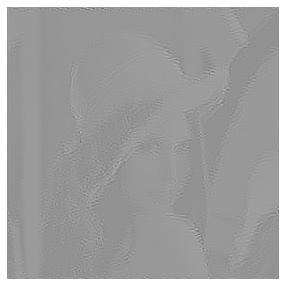

In [ ]:
# f = split_bregman(img_blurred, h, lamda=100, mu=1, sigma=2, nb_iterations=300)
f = split_bregman(img_blurred, h, lamda=200, mu=1*2, sigma=2, nb_iterations=300)
normalized = normalize(f)
grey_level = numpy.round(normalized*255).astype(numpy.uint8)
figure = matplotlib.pyplot.figure(figsize=(5, 5))
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
lasp.io.save(grey_level, path_output / 'res_lambda=200_mu=2_sigma=2_iter=300.png')

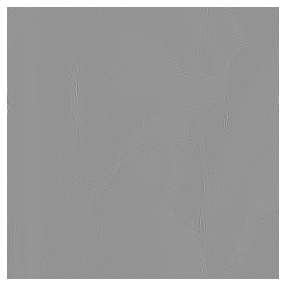

In [ ]:
f = split_bregman(img_blurred, h, lamda=40, mu=1, sigma=2, nb_iterations=300)
normalized = normalize(f)
grey_level = numpy.round(normalized*255).astype(numpy.uint8)
figure = matplotlib.pyplot.figure(figsize=(5, 5))
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(grey_level, cmap='gray')
lasp.io.save(grey_level, path_output / 'res_lambda=40_mu=1_sigma=2_iter=300.png')

In [ ]:
lasp.utils.circshift(
    numpy.array([ 1, -1 ]),
    shift=
)